In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import tqdm

In [1]:
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2025-02-01 12:51:33--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2025-02-01 12:51:34--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  20.8MB/s    in 4m 49s  

2025-02-01 12:56:23 (19.9 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



In [2]:
metadata_path = r"C:\Users\himan\Desktop\MTECH CSE 2025 SEMESTER 2\SU\Assignment_1\dataset\UrbanSound8K\UrbanSound8K\metadata\UrbanSound8K.csv";
metadata = pd.read_csv(metadata_path);
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Adding audio path to Dataframe


In [3]:
def adding_audio_path(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('C:/Users/himan/Desktop/MTECH CSE 2025 SEMESTER 2/SU/Assignment_1/dataset/UrbanSound8K/UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [4]:
metadata = adding_audio_path(metadata_path)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,C:/Users/himan/Desktop/MTECH CSE 2025 SEMESTER...
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,C:/Users/himan/Desktop/MTECH CSE 2025 SEMESTER...
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,C:/Users/himan/Desktop/MTECH CSE 2025 SEMESTER...
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,C:/Users/himan/Desktop/MTECH CSE 2025 SEMESTER...
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,C:/Users/himan/Desktop/MTECH CSE 2025 SEMESTER...


In [5]:
metadata.groupby('class').slice_file_name.count()

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: slice_file_name, dtype: int64

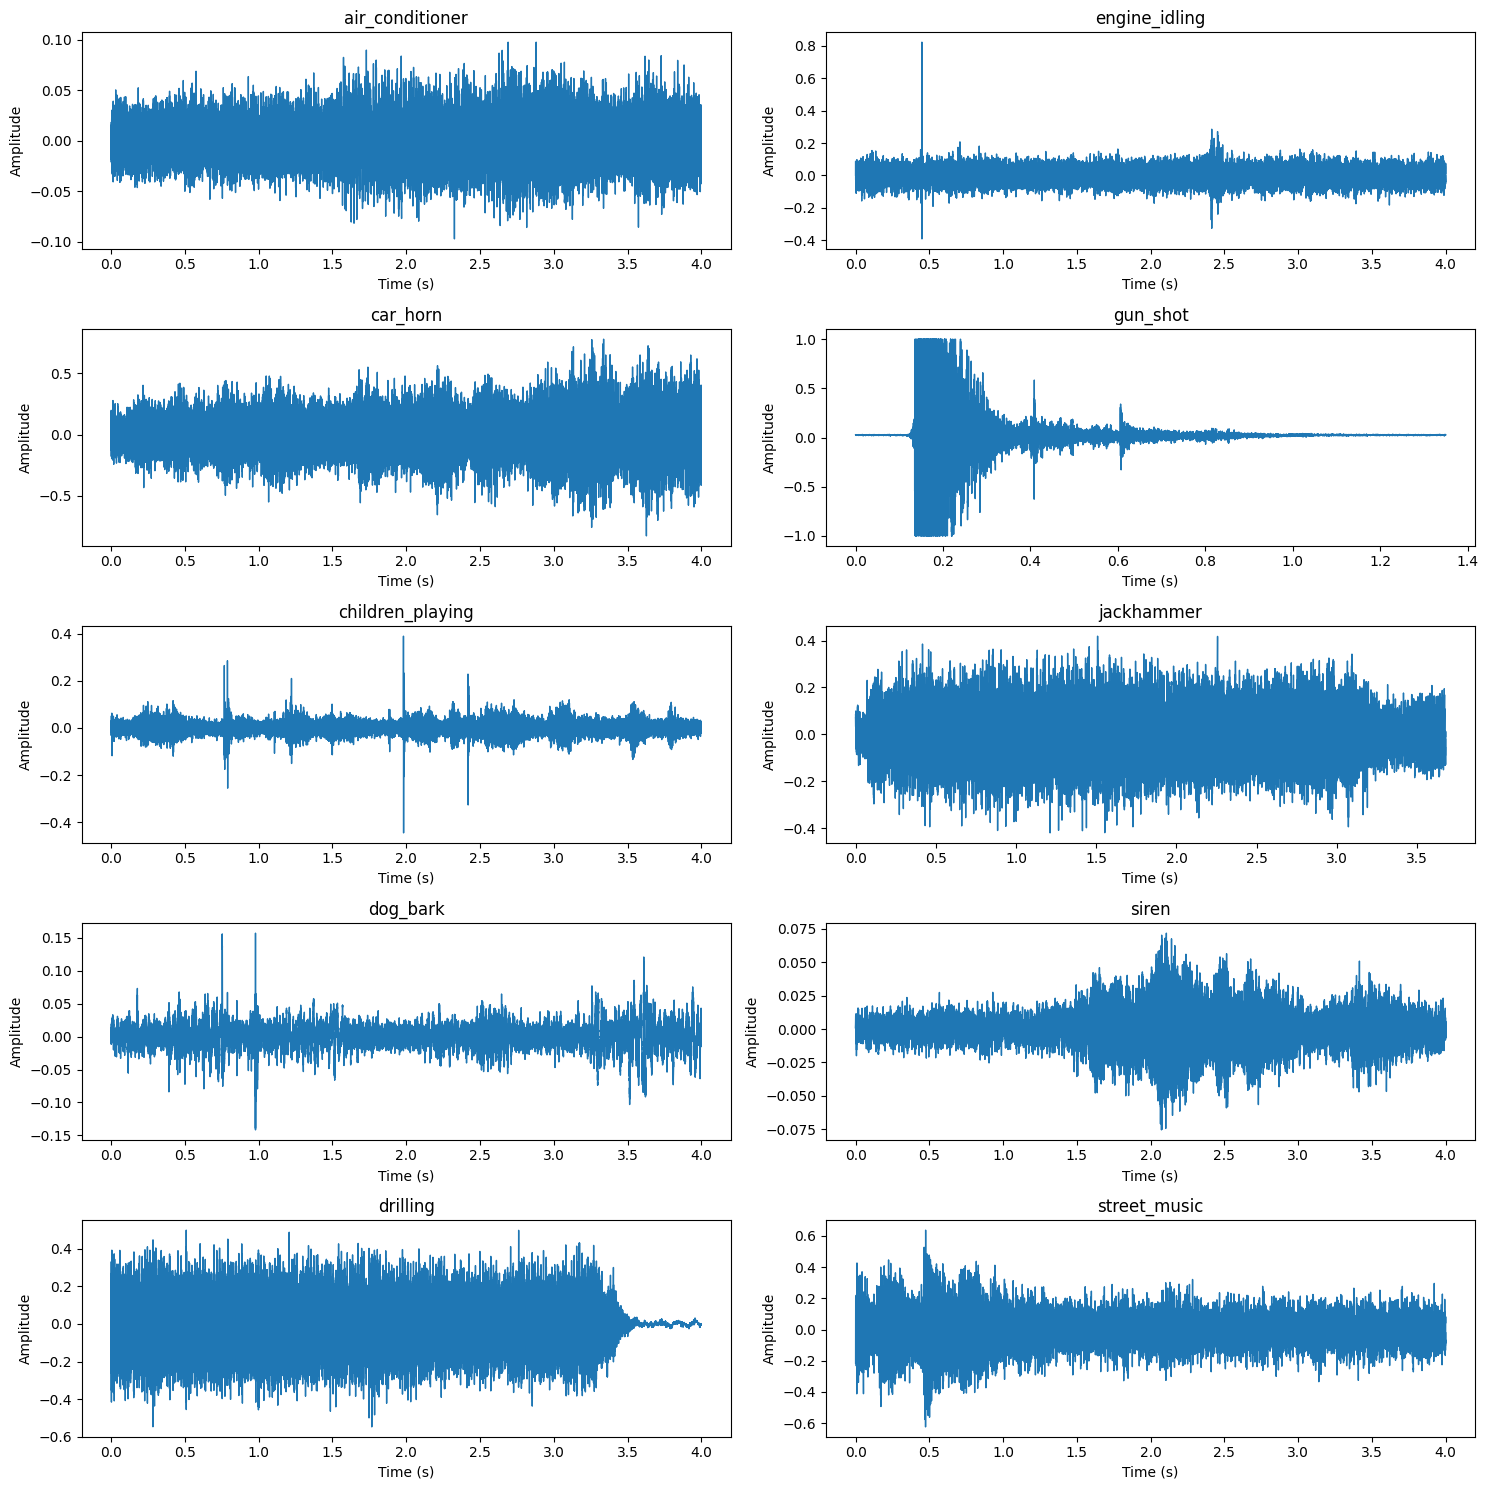

In [7]:
random_samples = metadata.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
index = 0
for col in range(2):
    for row in range(5):
        # Load audio file using torchaudio
        waveform, sample_rate = torchaudio.load(audio_samples[index])

        # Convert waveform tensor to numpy for plotting
        waveform = waveform.numpy()

        # Plot the waveform
        time_axis = torch.arange(0, waveform.shape[1]) / sample_rate
        axs[row, col].plot(time_axis, waveform[0], linewidth=1)  # Plot the first channel
        axs[row, col].set_title('{}'.format(labels[index]))
        axs[row, col].set_xlabel('Time (s)')
        axs[row, col].set_ylabel('Amplitude')
        index += 1

fig.tight_layout()
plt.show()

In [8]:
def hann_window(size):
    n = torch.arange(size, dtype=torch.float32)
    return 0.5 * (1 - torch.cos(2 * np.pi * n / (size - 1)))

def hamming_window(size):
    n = torch.arange(size, dtype=torch.float32)
    alpha, beta = 0.54, 0.46
    return alpha - beta * torch.cos(2 * np.pi * n / (size - 1))

def rectangular_window(size):
    return torch.ones(size, dtype=torch.float32)

In [9]:
def compute_spectrogram(waveform, window_fn, n_fft=2048, hop_length=512):
    window = window_fn(n_fft)
    stft = torch.stft(waveform, n_fft, hop_length, window=window, return_complex=True)
    spectrogram = torch.abs(stft)  # Convert to magnitude spectrogram
    return spectrogram

In [10]:
windowing_techniques = {
    'Hann Window': hann_window,
    'Hamming Window': hamming_window,
    'Rectangular Window': rectangular_window
}

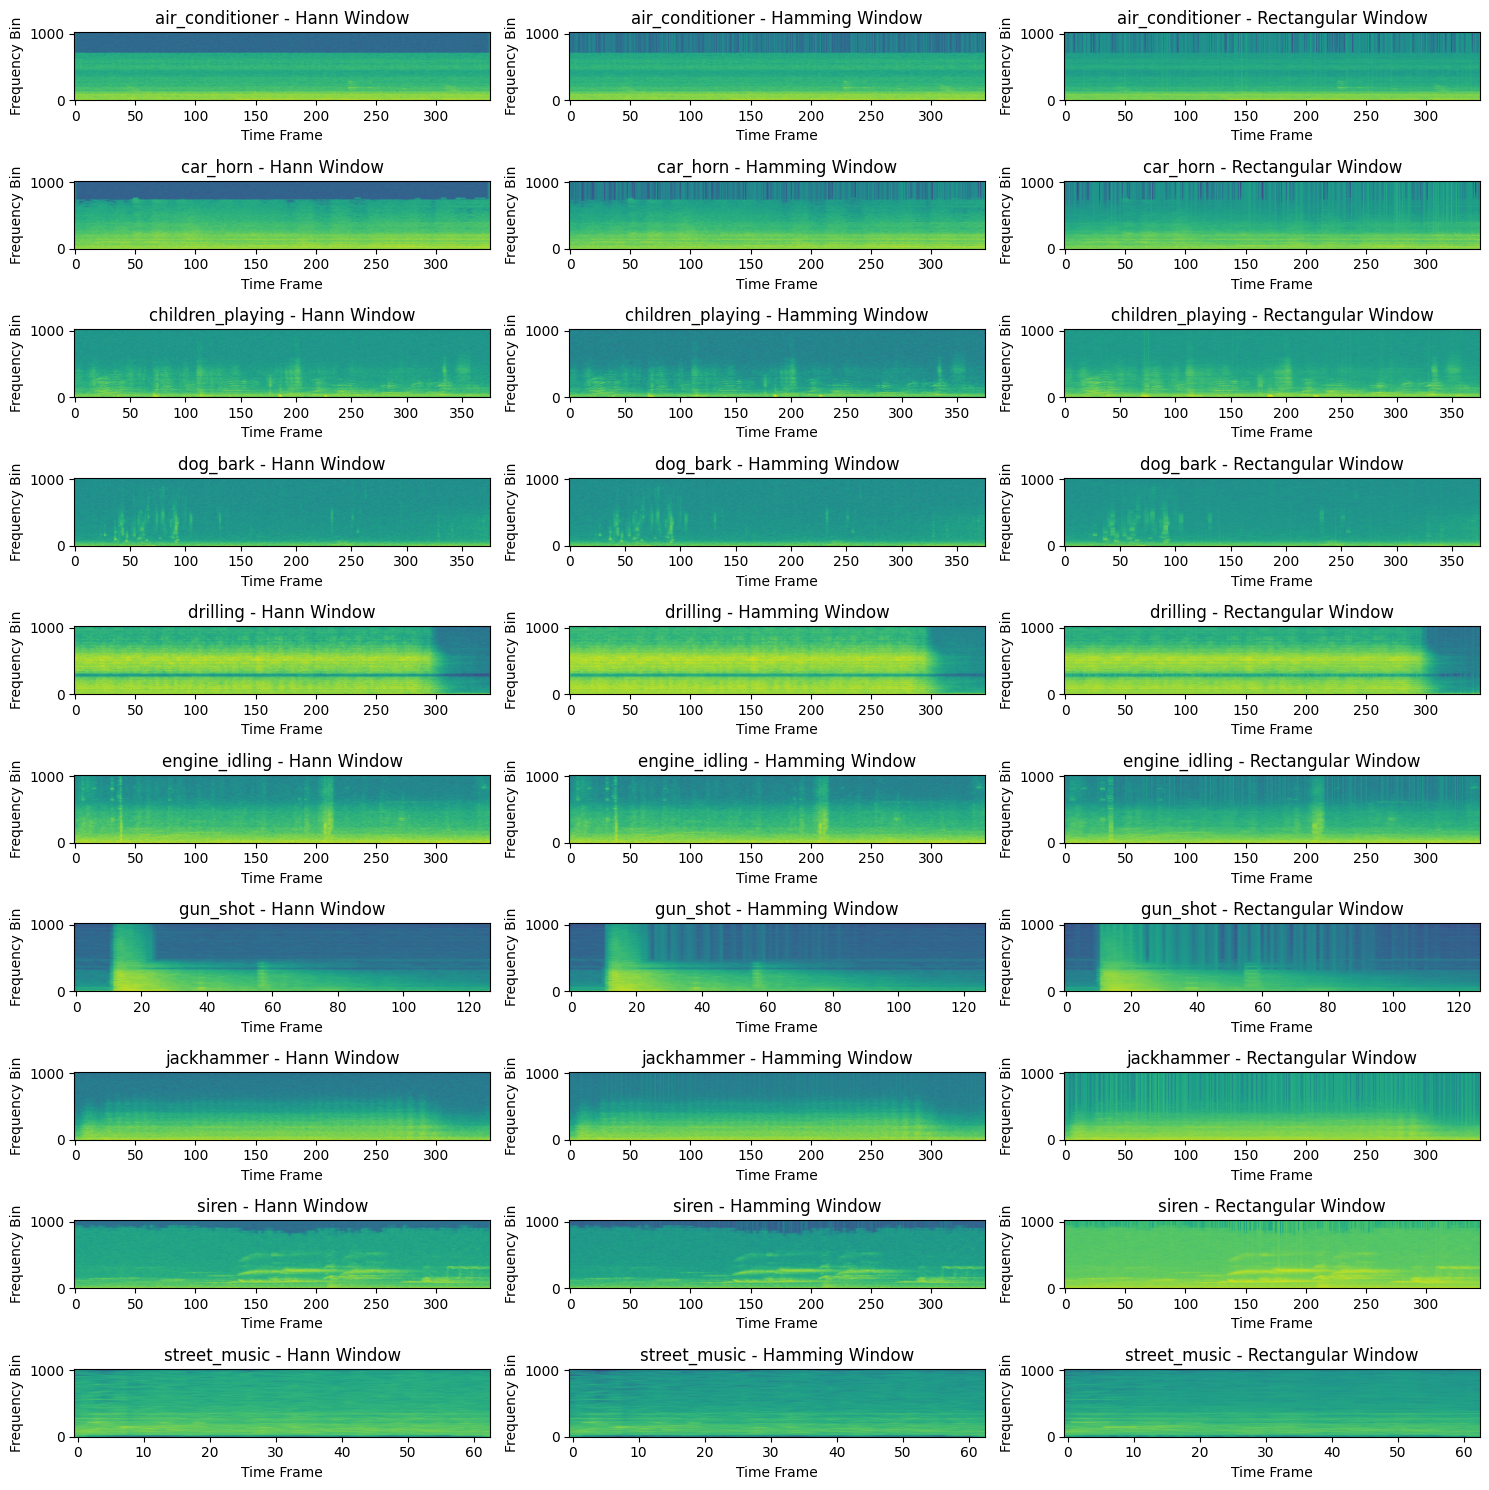

In [11]:
fig, axs = plt.subplots(len(audio_samples), len(windowing_techniques), figsize=(15, 15))
for i, (audio_file, label) in enumerate(zip(audio_samples, labels)):
    # Load audio file
    waveform, sample_rate = torchaudio.load(audio_file)

    # Compute and plot spectrograms for each windowing technique
    for j, (window_name, window_fn) in enumerate(windowing_techniques.items()):
        spectrogram = compute_spectrogram(waveform[0], window_fn)  # Use first channel
        spectrogram_db = 20 * torch.log10(spectrogram + 1e-10)  # Convert to dB scale

        # Plot spectrogram
        axs[i, j].imshow(spectrogram_db, cmap='viridis', origin='lower', aspect='auto')
        axs[i, j].set_title(f'{label} - {window_name}')
        axs[i, j].set_xlabel('Time Frame')
        axs[i, j].set_ylabel('Frequency Bin')

fig.tight_layout()
plt.show()

# **Training Neural Network**

In [12]:
from torch import nn
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader ,random_split
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050
train_ratio = 0.8

In [13]:
def split_dataset(dataset, train_ratio=0.8):
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_set, test_set = random_split(dataset, [train_size, test_size])
    return train_set, test_set

In [15]:
class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, target_sample_rate, num_samples, device, window_type="hann"):
        self.annotations = annotations_file
        self.device = device
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.window_type = window_type

        # Select the window function
        if window_type == "hann":
            window_fn = hann_window
        elif window_type == "hamming":
            window_fn = hamming_window
        elif window_type == "rectangular":
            window_fn = rectangular_window
        else:
            raise ValueError("Invalid window type! Choose from 'hann', 'hamming', 'rectangular'.")

        # Define spectrogram transformation with the selected window
        self.transformation = torchaudio.transforms.Spectrogram(
            n_fft=512,
            hop_length=256,
            power=2,
            window_fn=window_fn
        ).to(self.device)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)

        # Load and process audio
        signal, sr = torchaudio.load(audio_path)
        signal = signal.to(self.device)
        signal = self._resample_if_needed(signal, sr)
        signal = self._mix_to_mono_if_needed(signal)
        signal = self._trim_or_pad(signal)

        # Convert to spectrogram
        spectrogram = self.transformation(signal)

        return spectrogram, label

    def _trim_or_pad(self, signal):
        length = signal.shape[1]
        if length > self.num_samples:
            signal = signal[:, :self.num_samples]
        elif length < self.num_samples:
            padding = self.num_samples - length
            signal = torch.nn.functional.pad(signal, (0, padding))
        return signal

    def _resample_if_needed(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_to_mono_if_needed(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        return self.annotations.iloc[index]["filepath"]

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 6]

In [16]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f"Using device {device}")

Using device cpu


In [18]:
hann_dataset = UrbanSoundDataset(metadata, SAMPLE_RATE, NUM_SAMPLES, device, window_type="hann")
hamming_dataset = UrbanSoundDataset(metadata, SAMPLE_RATE, NUM_SAMPLES, device, window_type="hamming")
rectangular_dataset = UrbanSoundDataset(metadata, SAMPLE_RATE, NUM_SAMPLES, device, window_type="rectangular")
print(f"Hann dataset length: {len(hann_dataset)}")
print(f"Hamming dataset length: {len(hamming_dataset)}")
print(f"Rectangular dataset length: {len(rectangular_dataset)}")

Hann dataset length: 8732
Hamming dataset length: 8732
Rectangular dataset length: 8732


In [19]:
hann_train, hann_test = split_dataset(hann_dataset)
hamming_train, hamming_test = split_dataset(hamming_dataset)
rectangular_train, rectangular_test = split_dataset(rectangular_dataset)

In [20]:
hann_train_loader = DataLoader(hann_train, batch_size=32, shuffle=True)
hann_test_loader = DataLoader(hann_test, batch_size=32, shuffle=False)

hamming_train_loader = DataLoader(hamming_train, batch_size=32, shuffle=True)
hamming_test_loader = DataLoader(hamming_test, batch_size=32, shuffle=False)

rectangular_train_loader = DataLoader(rectangular_train, batch_size=32, shuffle=True)
rectangular_test_loader = DataLoader(rectangular_test, batch_size=32, shuffle=False)

In [22]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  # Ensures consistent output size
        self.fc = nn.Linear(64 * 4 * 4, num_classes)  # Fully connected layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.fc(x)  # No softmax (handled by CrossEntropyLoss)
        return x


In [26]:
import tqdm
from tqdm import tqdm
def train_and_validate(model, train_loader, val_loader, num_epochs=5, device='cpu'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Lists to store metrics
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for spectrograms, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Compute training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        val_loss, val_accuracy = validate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Print epoch statistics
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
    return train_losses, train_accuracies, val_losses, val_accuracies

def validate_model(model, val_loader, criterion, device='cpu'):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for spectrograms, labels in val_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [28]:
print("\nTraining with Hann window")
model_hann = SimpleCNN().to(device)
hann_train_losses, hann_train_accuracies, hann_val_losses, hann_val_accuracies = train_and_validate(
    model_hann, hann_train_loader, hann_test_loader, num_epochs=5, device=device
)

# Train with Hamming window
print("\nTraining with Hamming window")
model_hamming = SimpleCNN().to(device)
hamming_train_losses, hamming_train_accuracies, hamming_val_losses, hamming_val_accuracies = train_and_validate(
    model_hamming, hamming_train_loader, hamming_test_loader, num_epochs=5, device=device
)

# Train with Rectangular window
print("\nTraining with Rectangular window")
model_rectangular = SimpleCNN().to(device)
rectangular_train_losses, rectangular_train_accuracies, rectangular_val_losses, rectangular_val_accuracies = train_and_validate(
    model_rectangular, rectangular_train_loader, rectangular_test_loader, num_epochs=5, device=device
)


Training with Hann window


Epoch 1/5: 100%|██████████| 219/219 [02:06<00:00,  1.73it/s]


Epoch [1/5], Training Loss: 2.0243, Training Accuracy: 30.52%, Validation Loss: 1.9041, Validation Accuracy: 35.55%


Epoch 2/5: 100%|██████████| 219/219 [01:14<00:00,  2.93it/s]


Epoch [2/5], Training Loss: 1.7005, Training Accuracy: 41.57%, Validation Loss: 1.6466, Validation Accuracy: 46.65%


Epoch 3/5: 100%|██████████| 219/219 [01:13<00:00,  2.98it/s]


Epoch [3/5], Training Loss: 1.5575, Training Accuracy: 47.27%, Validation Loss: 1.5678, Validation Accuracy: 51.69%


Epoch 4/5: 100%|██████████| 219/219 [01:19<00:00,  2.74it/s]


Epoch [4/5], Training Loss: 1.4510, Training Accuracy: 51.14%, Validation Loss: 1.6021, Validation Accuracy: 47.22%


Epoch 5/5: 100%|██████████| 219/219 [01:15<00:00,  2.88it/s]


Epoch [5/5], Training Loss: 1.3804, Training Accuracy: 53.31%, Validation Loss: 1.5031, Validation Accuracy: 52.09%

Training with Hamming window


Epoch 1/5: 100%|██████████| 219/219 [01:11<00:00,  3.07it/s]


Epoch [1/5], Training Loss: 2.0222, Training Accuracy: 30.88%, Validation Loss: 1.8280, Validation Accuracy: 37.03%


Epoch 2/5: 100%|██████████| 219/219 [01:13<00:00,  2.98it/s]


Epoch [2/5], Training Loss: 1.6491, Training Accuracy: 43.26%, Validation Loss: 1.7080, Validation Accuracy: 41.73%


Epoch 3/5: 100%|██████████| 219/219 [01:11<00:00,  3.06it/s]


Epoch [3/5], Training Loss: 1.5350, Training Accuracy: 47.14%, Validation Loss: 1.5885, Validation Accuracy: 47.34%


Epoch 4/5: 100%|██████████| 219/219 [01:09<00:00,  3.16it/s]


Epoch [4/5], Training Loss: 1.4347, Training Accuracy: 50.75%, Validation Loss: 1.5335, Validation Accuracy: 51.06%


Epoch 5/5: 100%|██████████| 219/219 [01:09<00:00,  3.17it/s]


Epoch [5/5], Training Loss: 1.3558, Training Accuracy: 53.97%, Validation Loss: 1.4933, Validation Accuracy: 51.46%

Training with Rectangular window


Epoch 1/5: 100%|██████████| 219/219 [01:09<00:00,  3.14it/s]


Epoch [1/5], Training Loss: 2.2016, Training Accuracy: 30.91%, Validation Loss: 1.8950, Validation Accuracy: 35.83%


Epoch 2/5: 100%|██████████| 219/219 [01:10<00:00,  3.09it/s]


Epoch [2/5], Training Loss: 1.6902, Training Accuracy: 42.05%, Validation Loss: 1.6735, Validation Accuracy: 46.82%


Epoch 3/5: 100%|██████████| 219/219 [01:10<00:00,  3.09it/s]


Epoch [3/5], Training Loss: 1.5598, Training Accuracy: 46.51%, Validation Loss: 1.6046, Validation Accuracy: 49.28%


Epoch 4/5: 100%|██████████| 219/219 [01:10<00:00,  3.13it/s]


Epoch [4/5], Training Loss: 1.4615, Training Accuracy: 50.68%, Validation Loss: 1.5234, Validation Accuracy: 53.46%


Epoch 5/5: 100%|██████████| 219/219 [01:10<00:00,  3.10it/s]


Epoch [5/5], Training Loss: 1.3991, Training Accuracy: 52.51%, Validation Loss: 1.5337, Validation Accuracy: 53.23%


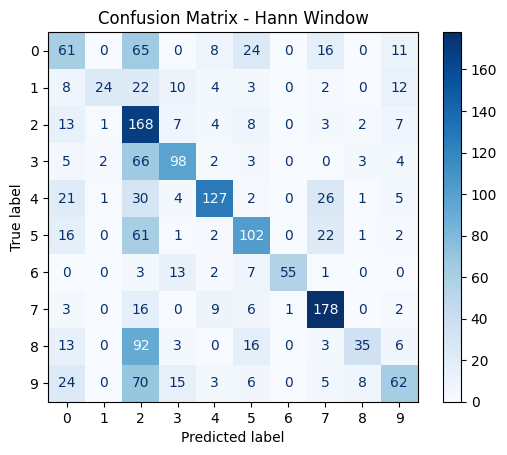

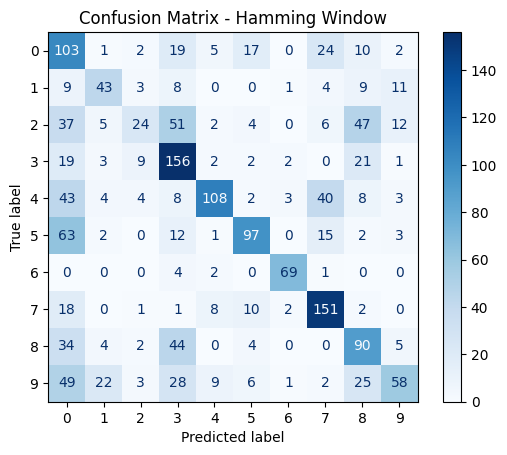

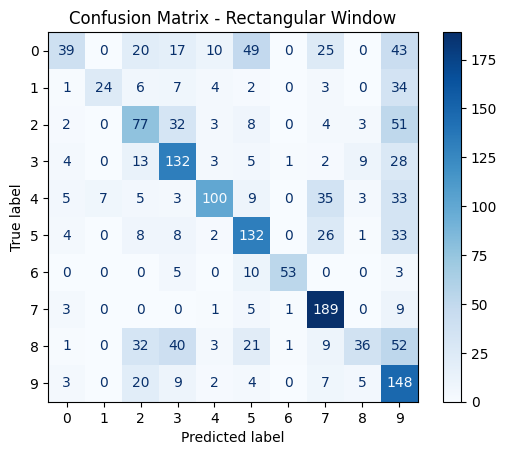

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_loader, window_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {window_name} Window")
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(model_hann, hann_test_loader, "Hann")
plot_confusion_matrix(model_hamming, hamming_test_loader, "Hamming")
plot_confusion_matrix(model_rectangular, rectangular_test_loader, "Rectangular")